In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio as iio
import nltk as nlp
import contractions
import string
import sys

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from functools import partial
from multiprocessing import cpu_count, Pool, current_process
from typing import Callable
from unicodedata import category


RS = 47
# nlp.download('stopwords')
# nlp.download('wordnet')
# nlp.download('omw-1.4')

In [9]:
df = pd.read_csv('processed_standardized.csv')

y = df['round_winner']
df.drop('round_winner', axis=1, inplace=True)

df.head(5)

time_left  ct_score   t_score      map  bomb_planted  ct_health  t_health  \
0   1.415828 -1.400576 -1.405702 -1.30641     -0.354764   0.664386  0.695301   
1   1.067531 -1.400576 -1.405702 -1.30641     -0.354764   0.664386  0.695301   
2  -0.034094 -1.400576 -1.405702 -1.30641     -0.354764  -0.159544 -0.019401   
3  -0.401302 -1.400576 -1.405702 -1.30641     -0.354764  -0.159544 -0.019401   
4   1.415277 -1.191823 -1.405702 -1.30641     -0.354764   0.664386  0.695301   

   ct_armor   t_armor  ct_money  ...  ct_grenade_flashbang  \
0 -1.836777 -1.709542 -0.516186  ...             -1.045338   
1  0.502008  0.008909 -0.819351  ...             -1.045338   
2 -0.117770 -0.563908 -0.805977  ...             -1.045338   
3 -0.117770 -0.563908 -0.805977  ...             -1.045338   
4 -0.714160 -1.709542  0.763351  ...             -1.045338   

   t_grenade_flashbang  ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0            -1.035461                -0.886648               -0.889569   
1            -1.035461                -0.886648                0.203841   
2            -1.035461                -0.886648                0.203841   
3            -1.035461                -0.886648               -0.889569   
4            -1.035461                -0.886648               -0.889569   

   ct_grenade_incendiarygrenade  t_grenade_incendiarygrenade  \
0                     -0.687185                    -0.137694   
1                     -0.687185                    -0.137694   
2                     -0.687185                    -0.137694   
3                     -0.687185                    -0.137694   
4                     -0.687185                    -0.137694   

   ct_grenade_molotovgrenade  t_grenade_molotovgrenade  \
0                  -0.210881                 -0.812929   
1                  -0.210881                 -0.812929   
2                  -0.210881                 -0.812929   
3                  -0.210881                 -0.812929   
4                  -0.210881                 -0.812929   

   ct_grenade_decoygrenade  t_grenade_decoygrenade  
0                -0.163356               -0.156855  
1                -0.163356               -0.156855  
2                -0.163356               -0.156855  
3                -0.163356               -0.156855  
4                -0.163356               -0.156855  

[5 rows x 90 columns]

# PCA

In [10]:
def transform_pca(X, n):

    pca = PCA(n_components=n, random_state=RS)
    X_new = pca.fit_transform(X)
#     pca.fit(X)
#     X_new = pca.inverse_transform(pca.transform(X))

    return X_new

In [11]:
X_new = transform_pca(df, 2)

Text(0.5, 1.0, 'PCA Components: 2')

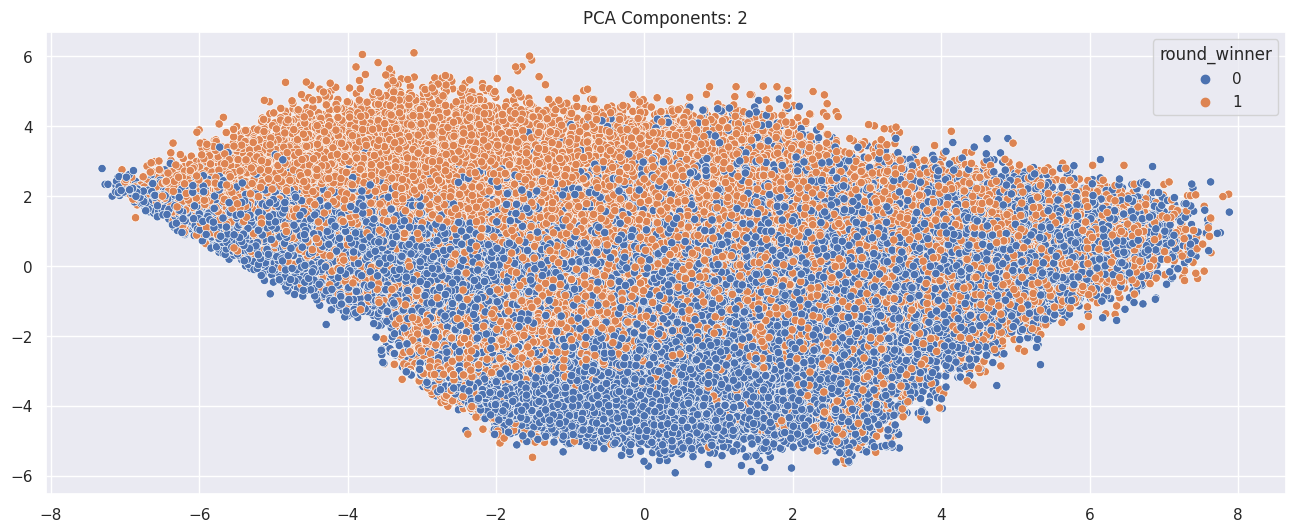

In [13]:
plt.figure(figsize=(16, 6))

sns.set(style="darkgrid")
sns.scatterplot(x=X_new[:, 0], y=X_new[:, 1], hue=y)

plt.title('PCA Components: 2')

# TSNE

In [14]:
def transform_tsne(X, n):

    tsne = TSNE(n_components=n, perplexity=40, n_iter=300, n_jobs=-1, random_state=RS)
    X_new = tsne.fit_transform(X)

    return X_new

In [15]:
X_new = transform_tsne(df, 2)

/home/henitsoi/kpi/data_analysis/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/henitsoi/kpi/data_analysis/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'TSNE Components: 2')

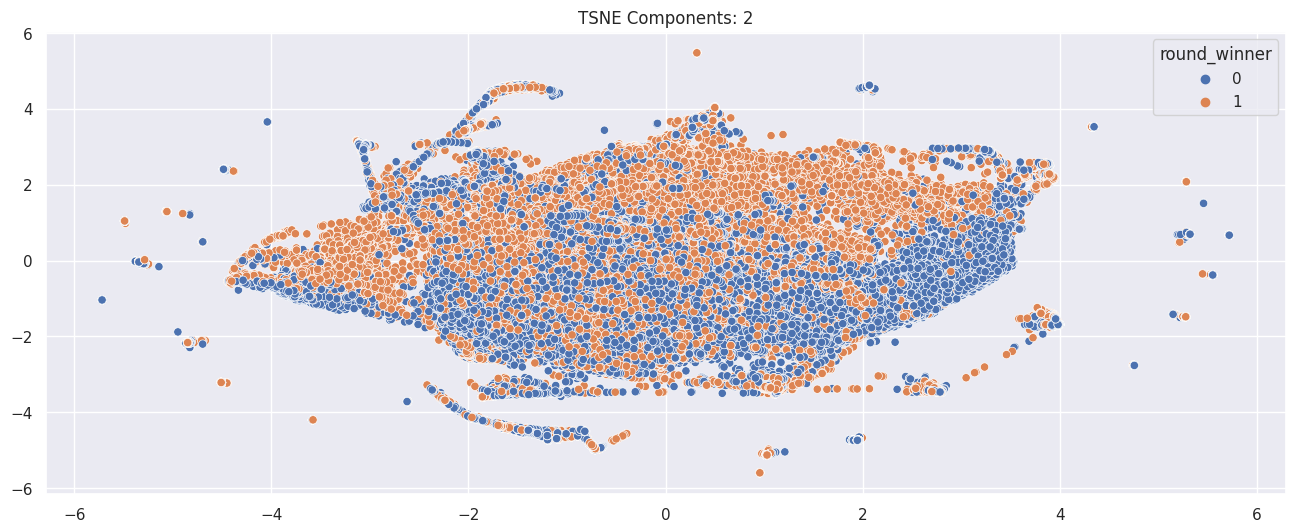

In [16]:
plt.figure(figsize=(16, 6))

sns.set(style="darkgrid")
sns.scatterplot(x=X_new[:, 0], y=X_new[:, 1], hue=y)

plt.title('TSNE Components: 2')

# KMeans

In [96]:
nature = iio.v3.imread("nature.jpg")
nature = np.array(nature, dtype=np.float64) / 255

nature.shape

In [98]:
# transform to a 2D numpy array.
w, h, d = nature.shape

assert d == 3

image_array = np.reshape(nature, (w * h, d))
image_array.shape

(4364800, 3)

In [115]:
def get_array_after_clusterization(X: np.ndarray, n: int, w: int, h: int) -> np.ndarray:
    kmeans = KMeans(n_clusters=n, random_state=RS).fit(X)
    labels = kmeans.predict(X)
    
    return kmeans.cluster_centers_[labels].reshape(w, h, -1)

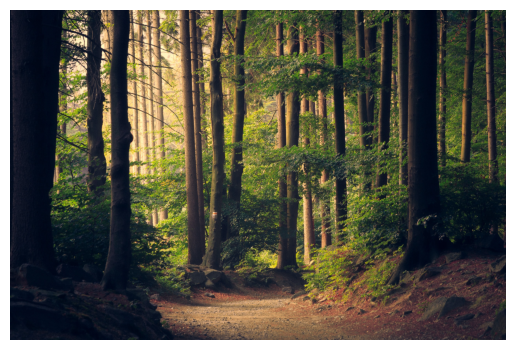

In [116]:
plt.axis("off")
plt.imshow(nature)

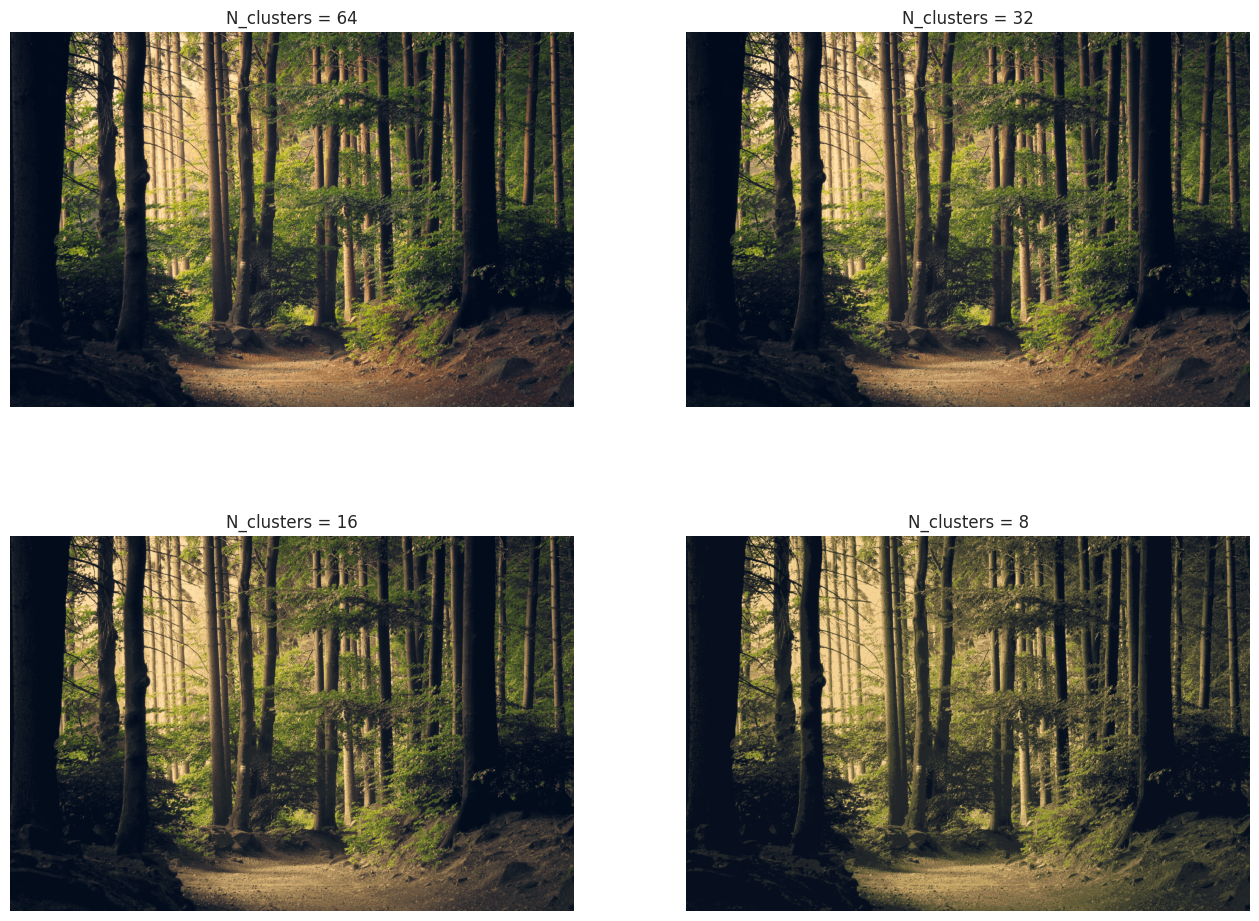

In [133]:
_, axes = plt.subplots(2, 2, figsize=(16,12))

for row, i in enumerate([(64, 32), (16, 8)]):
    for col, j in enumerate(i):
        axes[row, col].imshow(get_array_after_clusterization(image_array, j, w, h))

        axes[row, col].axis("off")
        axes[row, col].set_title(f'N_clusters = {j}')

# Text Classification

### https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

In [2]:
df = pd.read_csv('fake_job_postings.csv')

df.head(3)

job_id                                      title          location  \
0       1                           Marketing Intern  US, NY, New York   
1       2  Customer Service - Cloud Video Production    NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)     US, IA, Wever   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   

  required_education                   industry          function  fraudulent  
0                NaN                        NaN         Marketing           0  
1                NaN  Marketing and Advertising  Customer Service           0  
2                NaN                        NaN               NaN           0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
df.corr().fraudulent

/tmp/ipykernel_3360/3262856800.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().fraudulent


job_id              0.079872
telecommuting       0.034523
has_company_logo   -0.261971
has_questions      -0.091627
fraudulent          1.000000
Name: fraudulent, dtype: float64

In [5]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [7]:
df.drop(['job_id', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions'], axis=1, inplace=True)

In [8]:
df.duplicated().sum()

299

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.fillna('', inplace=True)

In [11]:
df.fraudulent.value_counts()

0    16726
1      855
Name: fraudulent, dtype: int64

In [12]:
df.nunique()

title                  11231
location                3106
department              1338
company_profile         1710
description            14802
requirements           11969
benefits                6206
employment_type            6
required_experience        8
required_education        14
industry                 132
function                  38
fraudulent                 2
dtype: int64

In [16]:
text_cols = df.columns[:-1].to_list()

df['text'] = df[text_cols].apply(lambda x: ' '.join(x), axis=1)

df.drop(text_cols, axis=1, inplace=True)

In [17]:
df.text[0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [19]:
df.head(3)

fraudulent                                               text
0           0  Marketing Intern US, NY, New York Marketing We...
1           0  Customer Service - Cloud Video Production NZ, ...
2           0  Commissioning Machinery Assistant (CMA) US, IA...

In [20]:
def processing_text(text: str, punctuation: str) -> str:
    t = contractions.fix(text)
    t = t.lower()
    t = t.translate(str.maketrans('', '', punctuation))
    t = ' '.join([word for word in t.split() if word not in stopwords.words('english') and not any(letter.isdigit() for letter in word)])
    t = ' '.join(list(filter(lambda x: len(x) > 1, [WordNetLemmatizer().lemmatize(word) for word in t.split()])))
    t = t.strip()
    return t

In [21]:
def run_processing(df: pd.DataFrame, col: str, punct: str) -> pd.DataFrame:
    df[col] = df[col].apply(lambda x: processing_text(x, punct))
    return df

In [22]:
def parallelize(func: Callable, data: pd.DataFrame, kwargs: dict = {}, n_jobs=None) -> pd.DataFrame:
    if n_jobs is None:
        cores = cpu_count()
    else:
        cores = n_jobs

    available_data = data.shape[0]
    if available_data < cores:
        cores = available_data

    data_split = np.array_split(data, cores)
    with Pool(cores) as pool:
        data = pd.concat(pool.map(partial(func, **kwargs), data_split), ignore_index=True)
        
    return data

In [23]:
chrs = (chr(i) for i in range(sys.maxunicode + 1))
punctuation = set(c for c in chrs if category(c).startswith("P")) | set(string.punctuation)

In [24]:
df_processed = parallelize(run_processing, df, {'col': 'text', 'punct': ''.join(punctuation)})

In [25]:
df_processed.text[3]

'account executive washington dc dc washington sale passion improving quality life geography heart everything esris geographic information system gi technology inspires enables government university business worldwide save money life environment deeper understanding changing world around themcarefully managed growth zero debt give esri stability uncommon today volatile business world privately held offer exceptional benefit competitive salary profitsharing program opportunity personal professional growth much company esri environmental system research instituteour passion improving quality life geography heart everything esris geographic information system gi technology inspires enables government university business worldwide save money life environment deeper understanding changing world around themcarefully managed growth zero debt give esri stability uncommon today volatile business world privately held offer exceptional benefit competitive salary profitsharing program opportunity 

(-0.5, 1399.5, 799.5, -0.5)

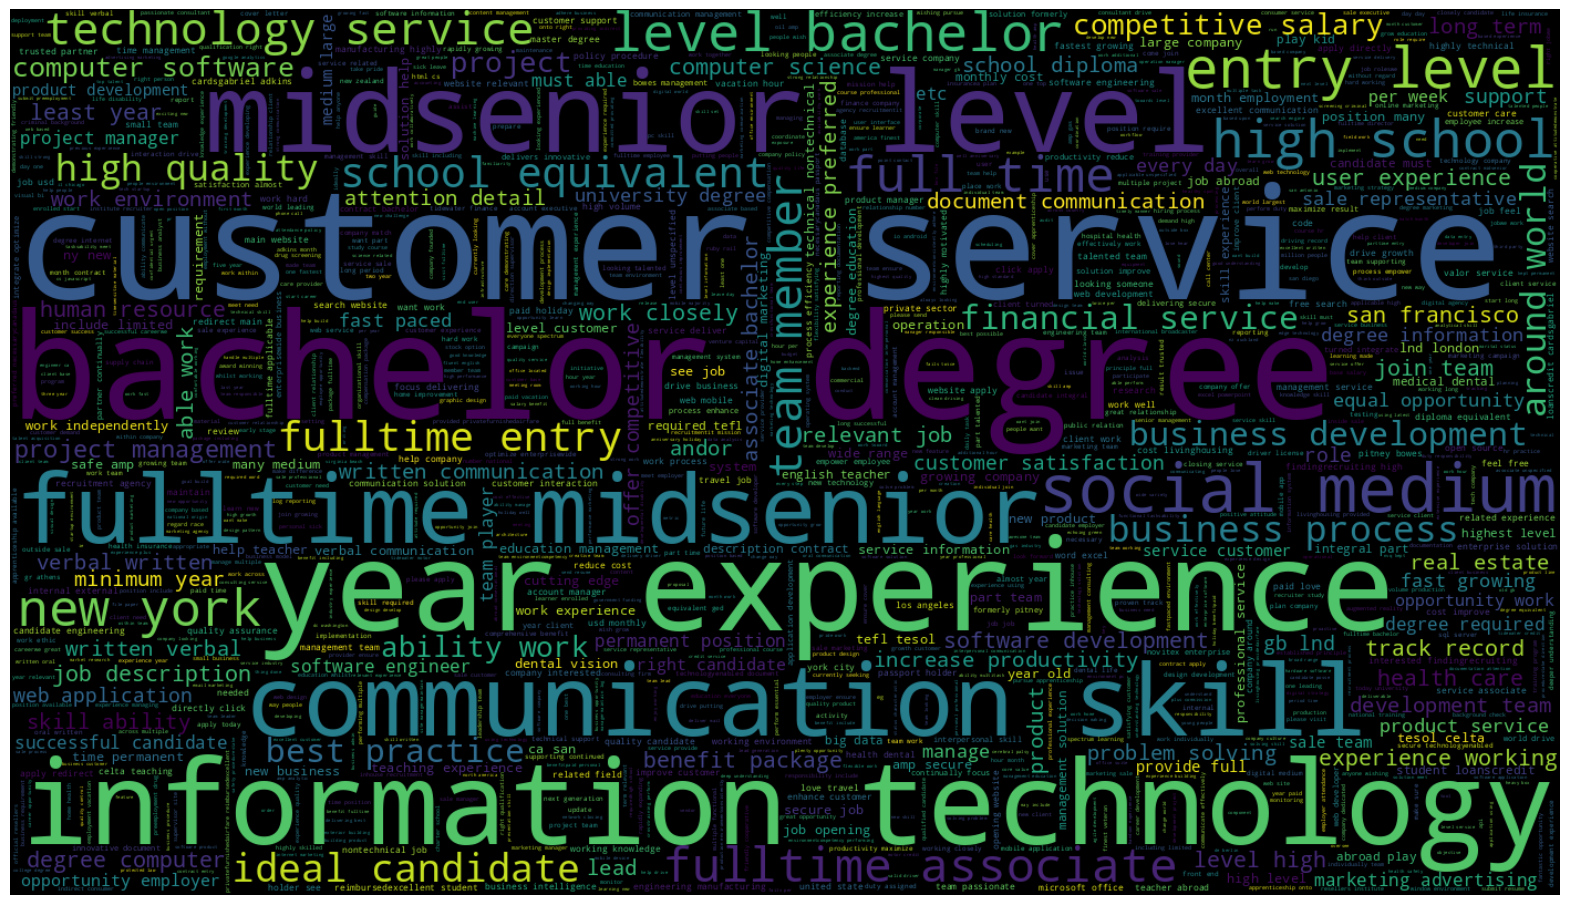

In [28]:
out = " ".join(df_processed[df_processed.fraudulent == 0].text)

plt.figure(figsize=(20, 16))
wc = WordCloud(width=1400 , height=800 , max_words=3000).generate(out)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 1399.5, 799.5, -0.5)

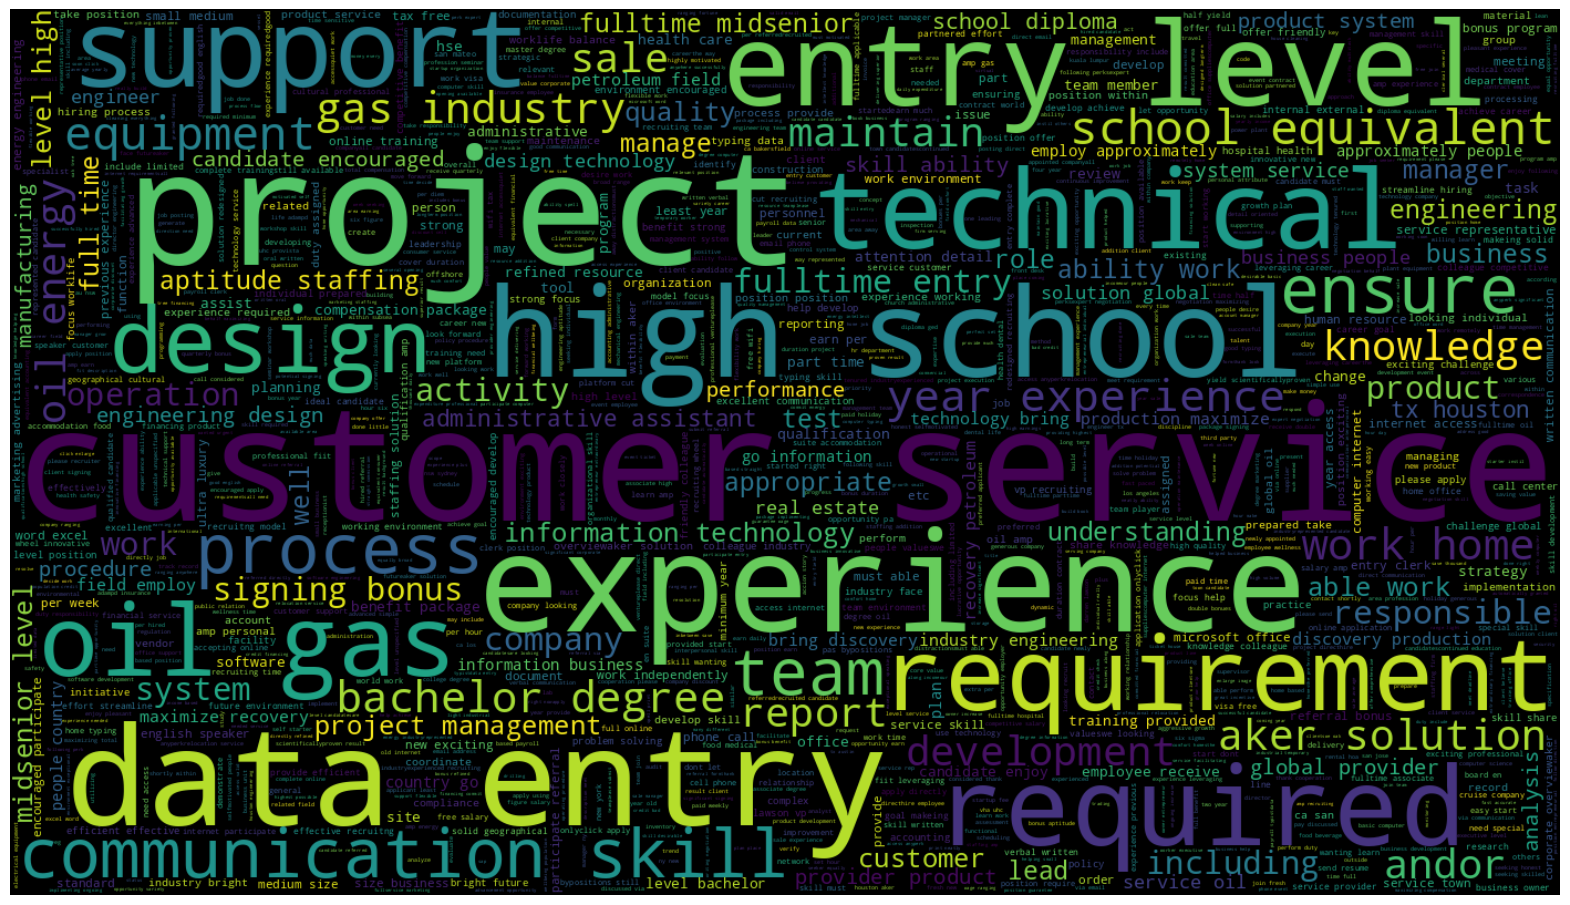

In [29]:
out = " ".join(df_processed[df_processed.fraudulent == 1].text)

plt.figure(figsize=(20, 16))
wc = WordCloud(width=1400 , height=800 , max_words=3000).generate(out)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [31]:
tvect = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
X = tvect.fit_transform(df_processed['text'])

print(f'tvect_df_processed shape = {X.shape}')

tvect_df_processed shape = (17581, 1162647)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, df_processed['fraudulent'], shuffle=True, test_size=0.2, random_state=RS)

print(f'X_train={X_train.shape}, y_train={y_train.shape}\nX_test={X_test.shape}, y_test={y_test.shape}')

X_train=(14064, 1162647), y_train=(14064,)
X_test=(3517, 1162647), y_test=(3517,)


In [58]:
y_test[y_test == 1].shape

(182,)

In [62]:
X[0].T

<1162647x1 sparse matrix of type '<class 'numpy.float64'>'
	with 424 stored elements in Compressed Sparse Column format>

In [33]:
tmp = pd.DataFrame(X[0].T.todense(), index=tvect.get_feature_names_out(), columns=["tfidf"])
tmp.sort_values(by=["tfidf"], ascending=False)

tfidf
food                      0.160587
cooking                   0.155591
affiliate                 0.148404
james beard               0.091815
beard                     0.091208
...                            ...
facility gymmodern        0.000000
facility gymopen          0.000000
facility gymregular       0.000000
facility gymsuccessbased  0.000000
ﬂexible take              0.000000

[1162647 rows x 1 columns]

# MultinomialNB

In [43]:
NBcls = MultinomialNB()

NBcls.fit(X_train, y_train)

MultinomialNB()

In [44]:
NBcls.score(X_test, y_test)

0.9482513505828831

In [45]:
predict_NBcls = NBcls.predict(X_test)
print(classification_report(y_test, predict_NBcls))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3335
           1       0.00      0.00      0.00       182

    accuracy                           0.95      3517
   macro avg       0.47      0.50      0.49      3517
weighted avg       0.90      0.95      0.92      3517



/home/henitsoi/kpi/data_analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/henitsoi/kpi/data_analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/henitsoi/kpi/data_analysis/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

/home/henitsoi/kpi/data_analysis/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


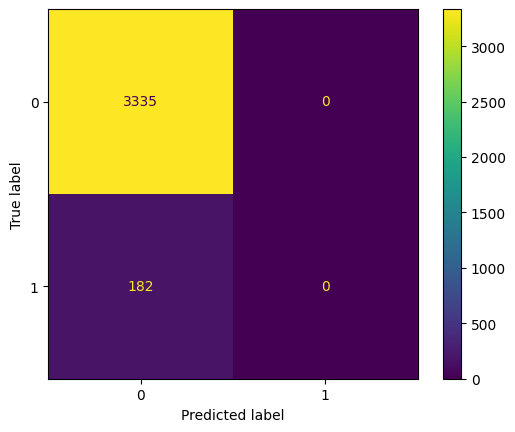

In [46]:
plot_confusion_matrix(NBcls, X_test, y_test)

In [47]:
confusion_matrix(y_test, predict_NBcls)

array([[3335,    0],
       [ 182,    0]])

# RandomForestClassifier

In [49]:
RFcls = RandomForestClassifier(n_jobs=-1, random_state=RS)

RFcls.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=47)

In [50]:
RFcls.score(X_test, y_test)

0.9812340062553313

In [51]:
predict_RFcls = RFcls.predict(X_test)
print(classification_report(y_test, predict_RFcls))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3335
           1       0.99      0.64      0.78       182

    accuracy                           0.98      3517
   macro avg       0.99      0.82      0.89      3517
weighted avg       0.98      0.98      0.98      3517



/home/henitsoi/kpi/data_analysis/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


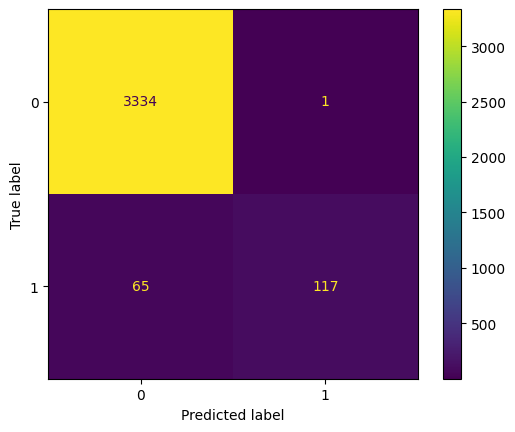

In [52]:
plot_confusion_matrix(RFcls, X_test, y_test)

In [53]:
confusion_matrix(y_test, predict_RFcls)

array([[3334,    1],
       [  65,  117]])

In [56]:
f1_score(y_test, predict_RFcls)

0.78